# Feature set 1


In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from tqdm import tqdm
import librosa
from keras.utils.np_utils import to_categorical
from sklearn.model_selection import train_test_split
import time
from keras.callbacks import EarlyStopping

from keras import Sequential
from keras.layers import Dense,Conv2D,MaxPooling2D,Flatten,Dropout,merge,Activation

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

#### Extracting data from csv files into numpy arrays

In [22]:
#extracting data from csv files into numpy arrays
from numpy import genfromtxt
files_data=np.array(['fold_data_1.csv','fold_data_2.csv','fold_data_3.csv','fold_data_4.csv','fold_data_5.csv',
                'fold_data_6.csv','fold_data_7.csv','fold_data_8.csv','fold_data_9.csv','fold_data_10.csv'])
X_folds= np.array([genfromtxt(file,delimiter=',') for file in files_data])

files_label=(['fold_labels_1.csv','fold_labels_2.csv','fold_labels_3.csv','fold_labels_4.csv','fold_labels_5.csv',
                'fold_labels_6.csv','fold_labels_7.csv','fold_labels_8.csv','fold_labels_9.csv','fold_labels_10.csv'])
Y_folds= np.array([genfromtxt(file,delimiter=',') for file in files_label])

In [23]:
def data_processor_cnn(X_fold,Y_fold):
    X_fold_processor_cnn = [0]*10
    Y_fold_processor_cnn = [0]*10
    Y_fold_processor_cnn=([to_categorical(Y_fold, num_classes=10) for Y_fold in Y_fold])
    for i in range(0, len(X_fold)):
        X_fold_processor_cnn[i]=np.reshape(X_fold[i],(X_fold[i].shape[0], 40, 6, 1))
    return X_fold_processor_cnn,Y_fold_processor_cnn

In [24]:
def data_processor_basic_nn(X_fold,Y_fold):
    X_fold_basic_nn = [0]*10
    Y_fold_basic_nn = [0]*10
    for i in range(0, len(Y_fold)):
        Y_fold_basic_nn[i]=np.reshape(Y_fold[i],(Y_fold[i].shape[0], 1))
    for i in range(0, len(X_fold)):
        X_fold_basic_nn[i]=np.reshape(X_fold[i],(X_fold[i].shape[0], 40, 6))
    return X_fold_basic_nn,Y_fold_basic_nn

In [25]:
def data_processor_log_reg(X_fold,Y_fold):
    X_fold_log_reg = [0]*10
    Y_fold_log_reg = [0]*10
    for i in range(0, len(Y_fold)):
        Y_fold_log_reg[i]=np.reshape(Y_fold[i],(Y_fold[i].shape[0], 1))
    for i in range(0, len(X_fold)):
        X_fold_log_reg[i]=np.reshape(X_fold[i],(X_fold[i].shape[0], 240))
    return X_fold_log_reg,Y_fold_log_reg

In [26]:
Data_cnn=data_processor_cnn(X_folds,Y_folds)
X_folds_10=Data_cnn[0]
Y_folds_10=Data_cnn[1]

In [27]:
Data_nn=data_processor_basic_nn(X_folds,Y_folds)
X_folds_1=Data_nn[0]
Y_folds_1=Data_nn[1]

In [28]:
Data_Linear=data_processor_log_reg(X_folds,Y_folds)
X_folds_2=Data_Linear[0]
Y_folds_2=Data_Linear[1]

#### Shapes of the data


In [29]:
for i in range((10)):
    print("X_data",i+1,"=",np.shape(X_folds_10[i]))
    print("Y_data",i+1,"=",np.shape(Y_folds_10[i]))
    
for i in range((10)):
    print("X_data",i+1,"=",np.shape(X_folds_1[i]))
    print("Y_data",i+1,"=",np.shape(Y_folds_1[i]))

X_data 1 = (873, 40, 6, 1)
Y_data 1 = (873, 10)
X_data 2 = (888, 40, 6, 1)
Y_data 2 = (888, 10)
X_data 3 = (925, 40, 6, 1)
Y_data 3 = (925, 10)
X_data 4 = (990, 40, 6, 1)
Y_data 4 = (990, 10)
X_data 5 = (936, 40, 6, 1)
Y_data 5 = (936, 10)
X_data 6 = (823, 40, 6, 1)
Y_data 6 = (823, 10)
X_data 7 = (838, 40, 6, 1)
Y_data 7 = (838, 10)
X_data 8 = (806, 40, 6, 1)
Y_data 8 = (806, 10)
X_data 9 = (816, 40, 6, 1)
Y_data 9 = (816, 10)
X_data 10 = (837, 40, 6, 1)
Y_data 10 = (837, 10)
X_data 1 = (873, 40, 6)
Y_data 1 = (873, 1)
X_data 2 = (888, 40, 6)
Y_data 2 = (888, 1)
X_data 3 = (925, 40, 6)
Y_data 3 = (925, 1)
X_data 4 = (990, 40, 6)
Y_data 4 = (990, 1)
X_data 5 = (936, 40, 6)
Y_data 5 = (936, 1)
X_data 6 = (823, 40, 6)
Y_data 6 = (823, 1)
X_data 7 = (838, 40, 6)
Y_data 7 = (838, 1)
X_data 8 = (806, 40, 6)
Y_data 8 = (806, 1)
X_data 9 = (816, 40, 6)
Y_data 9 = (816, 1)
X_data 10 = (837, 40, 6)
Y_data 10 = (837, 1)


## Defining Functions

## Simple nn models as function

In [30]:
def Model_run_nn(model_history,model,X_folds,Y_folds,Accuracy_array,accuracy_total,end_array,Epoch_array_accuracy,Loss_array,
             Fold_accuracy,Val_accuracy_array,Val_Loss_array, Confusion_Matrix_array, 
             Metrics_f1, Metrics_precision, Metrics_recall, Metrics_accuracy):
   
    fold=0
    for i in range(10):
        start = time.time()
        fold+=1
        print(f"\nFold #{fold}\n- - - - - - - - - - - - - - - - - - - -")

        x_train = np.vstack([X_folds[j] for j in range(0, len(Y_folds)) if i!=j])
        y_train = np.vstack([Y_folds[j] for j in range(0, len(Y_folds)) if i!=j])
        x_test = np.vstack([X_folds[j] for j in range(0, len(Y_folds)) if i==j])
        y_test = np.vstack([Y_folds[j] for j in range(0, len(Y_folds)) if i==j])
        print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)
    
        model_history = model.fit(x_train,y_train,batch_size=Batch_size,epochs=Epoch_number,validation_data=(x_test,y_test)
                                  ,verbose=0)
        
        model_evaluation = model.evaluate(x_test, y_test, verbose = 0)
        score=model_evaluation[1]
        accuracy_score.append(score)
        
        # Generate confusion matrix
        y_pred = model.predict_classes(x_test)
        cm = sklearn.metrics.confusion_matrix(y_test, y_pred)
        Confusion_Matrix_array.append(cm)
        
        # metrics
        f1 = sklearn.metrics.f1_score(y_test, y_pred, average='weighted')
        precision = sklearn.metrics.precision_score(y_test, y_pred, average='weighted')
        recall = sklearn.metrics.recall_score(y_test, y_pred, average='weighted')
        accuracy = sklearn.metrics.accuracy_score(y_test, y_pred)
        
        Metrics_f1.append(f1)
        Metrics_precision.append(precision)
        Metrics_recall.append(recall)
        Metrics_accuracy.append(accuracy)
        
        accuracy=model_history.history['acc']
        accuracy_avg=np.mean(accuracy)
        
        Fold_accuracy.append(accuracy_avg)
        print(f"Accuracy of Fold {fold} is {accuracy_avg}")
        end = time.time()
        print("Time to train Fold", fold,":",round(((end)- (start)),4),"seconds.")
        end_array.append(round(((end)- (start)),4))
        
    
        Epoch_array=model_history.history['acc']
        Epoch_array_accuracy.append(Epoch_array)
        loss=model_history.history['loss']
        Loss_array.append(loss)
    
        Epoch_val_array=model_history.history['val_acc']
        Val_accuracy_array.append(Epoch_val_array)
    
        loss_val=model_history.history['val_loss']
        Val_Loss_array.append(loss_val)
    
    Avg_Accuracy=np.mean(Fold_accuracy)       
    Time=sum(end_array)
    print("\n - - - - - - - - - - - - - - -\nThe average accuracy of the model:",(Avg_Accuracy))
    print("The time taken to run model:",Time)
    return Avg_Accuracy,Time

In [31]:
def Model_run_nn_es(model_history,model,X_folds,Y_folds,Accuracy_array,accuracy_total,end_array,Epoch_array_accuracy,Loss_array,
             Fold_accuracy,Val_accuracy_array,Val_Loss_array, Confusion_Matrix_array,
             Metrics_f1, Metrics_precision, Metrics_recall, Metrics_accuracy):
    
    for i in range(0, len(X_folds)):
        X_folds[i]=np.reshape(X_folds[i],(X_folds[i].shape[0], 40, 6, 1))
    fold=0
    for i in range(10):
        start = time.time()
        fold+=1
        print(f"\nFold #{fold}\n- - - - - - - - - - - - - - - - - - - -")

        x_train = np.vstack([X_folds[j] for j in range(0, len(Y_folds)) if i!=j])
        y_train = np.vstack([Y_folds[j] for j in range(0, len(Y_folds)) if i!=j])
        x_test = np.vstack([X_folds[j] for j in range(0, len(Y_folds)) if i==j])
        y_test = np.vstack([Y_folds[j] for j in range(0, len(Y_folds)) if i==j])
        print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)
    
        model_history = model.fit(x_train,y_train,epochs=Epoch_number,validation_data=(x_test,y_test)
                                  ,verbose=0, callbacks=[early_stopping_cb])
        
        model_evaluation = model.evaluate(x_test, y_test, verbose = 0)
        score=model_evaluation[1]
        accuracy_score.append(score)
        
        # Generate confusion matrix
        y_pred = model.predict_classes(x_test)
        # Reverse categorical y_test (used in CNN)
        y_test_a = np.argmax(y_test, axis=1)
#         print(y_test_a)
        cm = sklearn.metrics.confusion_matrix(y_test_a, y_pred)
        Confusion_Matrix_array.append(cm)
        
        # metrics
        f1 = sklearn.metrics.f1_score(y_test_a, y_pred, average='weighted')
        precision = sklearn.metrics.precision_score(y_test_a, y_pred, average='weighted')
        recall = sklearn.metrics.recall_score(y_test_a, y_pred, average='weighted')
        accuracy = sklearn.metrics.accuracy_score(y_test_a, y_pred)
        
        Metrics_f1.append(f1)
        Metrics_precision.append(precision)
        Metrics_recall.append(recall)
        Metrics_accuracy.append(accuracy)
        
        accuracy=model_history.history['acc']
        accuracy_avg=np.mean(accuracy)
        
        Fold_accuracy.append(accuracy_avg)
        print(f"Accuracy of Fold {fold} is {accuracy_avg}")
        end = time.time()
        print("Time to train Fold", fold,":",round(((end)- (start)),4),"seconds.")
        end_array.append(round(((end)- (start)),4))
        
    
        Epoch_array=model_history.history['acc']
        Epoch_array_accuracy.append(Epoch_array)
        loss=model_history.history['loss']
        Loss_array.append(loss)
    
        Epoch_val_array=model_history.history['val_acc']
        Val_accuracy_array.append(Epoch_val_array)
    
        loss_val=model_history.history['val_loss']
        Val_Loss_array.append(loss_val)
    
    Avg_Accuracy=np.mean(Fold_accuracy)       
    Time=sum(end_array)
    print("\n - - - - - - - - - - - - - - -\nThe average accuracy of the model:",(Avg_Accuracy))
    print("The time taken to run model:",Time)
    return Avg_Accuracy,Time

In [66]:
def Model_run_nn_es_NO_EARLY_STOPPING(model_history,model,X_folds,Y_folds,Accuracy_array,accuracy_total,end_array,Epoch_array_accuracy,Loss_array,
             Fold_accuracy,Val_accuracy_array,Val_Loss_array, Confusion_Matrix_array,
             Metrics_f1, Metrics_precision, Metrics_recall, Metrics_accuracy):
    
    for i in range(0, len(X_folds)):
        X_folds[i]=np.reshape(X_folds[i],(X_folds[i].shape[0], 40, 6, 1))
    fold=0
    for i in range(10):
        start = time.time()
        fold+=1
        print(f"\nFold #{fold}\n- - - - - - - - - - - - - - - - - - - -")

        x_train = np.vstack([X_folds[j] for j in range(0, len(Y_folds)) if i!=j])
        y_train = np.vstack([Y_folds[j] for j in range(0, len(Y_folds)) if i!=j])
        x_test = np.vstack([X_folds[j] for j in range(0, len(Y_folds)) if i==j])
        y_test = np.vstack([Y_folds[j] for j in range(0, len(Y_folds)) if i==j])
        print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)
    
        model_history = model.fit(x_train,y_train,epochs=Epoch_number,validation_data=(x_test,y_test)
                                  ,verbose=0)
        
        model_evaluation = model.evaluate(x_test, y_test, verbose = 0)
        score=model_evaluation[1]
        accuracy_score.append(score)
        
        # Generate confusion matrix
        y_pred = model.predict_classes(x_test)
        # Reverse categorical y_test (used in CNN)
        y_test_a = np.argmax(y_test, axis=1)
#         print(y_test_a)
        cm = sklearn.metrics.confusion_matrix(y_test_a, y_pred)
        Confusion_Matrix_array.append(cm)
        
        # metrics
        f1 = sklearn.metrics.f1_score(y_test_a, y_pred, average='weighted')
        precision = sklearn.metrics.precision_score(y_test_a, y_pred, average='weighted')
        recall = sklearn.metrics.recall_score(y_test_a, y_pred, average='weighted')
        accuracy = sklearn.metrics.accuracy_score(y_test_a, y_pred)
        
        Metrics_f1.append(f1)
        Metrics_precision.append(precision)
        Metrics_recall.append(recall)
        Metrics_accuracy.append(accuracy)
        
        accuracy=model_history.history['acc']
        accuracy_avg=np.mean(accuracy)
        
        Fold_accuracy.append(accuracy_avg)
        print(f"Accuracy of Fold {fold} is {accuracy_avg}")
        end = time.time()
        print("Time to train Fold", fold,":",round(((end)- (start)),4),"seconds.")
        end_array.append(round(((end)- (start)),4))
        
    
        Epoch_array=model_history.history['acc']
        Epoch_array_accuracy.append(Epoch_array)
        loss=model_history.history['loss']
        Loss_array.append(loss)
    
        Epoch_val_array=model_history.history['val_acc']
        Val_accuracy_array.append(Epoch_val_array)
    
        loss_val=model_history.history['val_loss']
        Val_Loss_array.append(loss_val)
    
    Avg_Accuracy=np.mean(Fold_accuracy)       
    Time=sum(end_array)
    print("\n - - - - - - - - - - - - - - -\nThe average accuracy of the model:",(Avg_Accuracy))
    print("The time taken to run model:",Time)
    return Avg_Accuracy,Time

### Graph plotting function

In [44]:
def Graph_func(Epoch_number,Epoch_array_accuracy,Val_accuracy_array,Loss_array,val_loss_array):
    %matplotlib inline
    
    fig,ax1 = plt.subplots(1, 1, constrained_layout=True, subplot_kw=dict())
    fig.suptitle(f"Accuracy of each Epoch for each Fold")
    ax1.set_xlabel("Epoch number")
    ax1.set_ylabel("Accuracy")
    ax1.grid()
    for i in range(10):
        ax1.plot(Epoch_array_accuracy[i],label=('Fold',i+1))
        ax1.legend(loc='center left', bbox_to_anchor=(1, 0.5))

    
    fig,ax1 = plt.subplots(1, 1, constrained_layout=True, subplot_kw=dict())
    fig.suptitle(f"Accuracy of each Epoch for each Fold")
    ax1.set_xlabel("Epoch number")
    ax1.set_ylabel("Val Accuracy")
    ax1.grid()
    for i in range(10):
        ax1.plot(Val_accuracy_array[i],label=('Fold',i+1))
        ax1.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    
    fig1,ax2 = plt.subplots(1, 1, constrained_layout=True, subplot_kw=dict())
    fig1.suptitle(f"Loss of each Epoch for each Fold")
    ax2.set_xlabel("Epoch")
    ax2.set_ylabel("Loss")
    ax2.grid()
    for i in range(10):
        ax2.plot(Loss_array[i],label=('Fold',i+1))
        ax2.legend(loc='center left', bbox_to_anchor=(1, 0.5))    
    
    fig1,ax2 = plt.subplots(1, 1, constrained_layout=True, subplot_kw=dict())
    fig1.suptitle(f"Val Loss of each Epoch for each Fold")
    ax2.set_xlabel("Epoch")
    ax2.set_ylabel("Val Loss")
    ax2.grid()
    for i in range(10):
        ax2.plot(val_loss_array[i],label=('Fold',i+1))
        ax2.legend(loc='center left', bbox_to_anchor=(1, 0.5))   

### Table making function

In [34]:
def table_maker(Fold_accuracy,end_array,Avg_Accuracy,Time):
    data= {'Fold': ['1','2','3','4','5','6','7','8','9','10'],
           'Accuracy': [Fold_accuracy[0],Fold_accuracy[1],Fold_accuracy[2],Fold_accuracy[3],Fold_accuracy[4],
                    Fold_accuracy[5],Fold_accuracy[6],Fold_accuracy[7],Fold_accuracy[8],Fold_accuracy[9]],
           'Time Taken' :[end_array[0],end_array[1],end_array[2],end_array[3],end_array[4],end_array[5],end_array[6],end_array[7],
                end_array[8],end_array[9]]}
    df = pd.DataFrame(data, columns = ['Fold', 'Accuracy','Time Taken'])
    data_avg={'Average Accuracy':[Avg_Accuracy],'Total Time':[Time]}
    df_avg=pd.DataFrame(data_avg,columns=['Average Accuracy','Total Time'])
    print (df)
    print ("\n",df_avg)

### Average graph function

In [35]:
def Graph_Avg_maker(Fold_accuracy,Avg_Accuracy):
    %matplotlib inline
    Fold_iteration=np.linspace(1,10,num=10)
    fig, ax1 = plt.subplots(1, 1, constrained_layout=True, subplot_kw=dict())
    ax1.plot(Fold_iteration,Fold_accuracy,"gx")
    ax1.axhline(y=Avg_Accuracy,label='Average Accuracy')
    fig.suptitle(f"Results for Batch size of {Batch_size}\n and Epoch number of {Epoch_number}\n for Feature set 1")
    ax1.set_xlabel("Fold iteration")
    ax1.set_ylabel("Accuracy")
    ax1.grid()
    ax1.legend(loc='center left', bbox_to_anchor=(1, 0.5))

### Confusion Matrix function 

In [36]:
import sklearn
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

def Confusion_matrix(x_test, y_test_a, model=None):

    if model == None:
        return 'Please pass a defined model to this function'
    
    # Create predictions
    try:
        y_test_pred = model.predict_classes(x_test)
    except:
        y_test_pred = model.predict(x_test)
    
    # Read file with the defined classes (should be available in every folder)
    classes = pd.read_csv("classes.csv")
    classes = classes['class'].tolist()
    
    # Create confusion matrix
    array = sklearn.metrics.confusion_matrix(y_test_a, y_test_pred)

    axis_labels = classes # labels for x and y axis

    # create seaborn heatmap with required labels
    plt.figure(figsize = (12, 10))
    sn.heatmap(array, annot=True, xticklabels=axis_labels, yticklabels=axis_labels)
    # fixing axis that are cut otherwise
    b, t = plt.ylim()
    b += 0.5
    t -= 0.5
    plt.ylim(b, t)
    plt.show()

In [37]:
import sklearn
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

def plot_confusion_matrix(cm):
    
    # Read file with the defined classes (should be available in every folder)
    classes = pd.read_csv("classes.csv")
    classes = classes['class'].tolist()
    
    # Read confusion matrix
    array = cm

    axis_labels = classes # labels for x and y axis

    # create seaborn heatmap with required labels
    plt.figure(figsize = (12, 10))
    sn.heatmap(array, annot=True, xticklabels=axis_labels, yticklabels=axis_labels)
    # fixing axis that are cut otherwise
    b, t = plt.ylim()
    b += 0.5
    t -= 0.5
    plt.ylim(b, t)
    plt.show()

In [38]:
def average_confusion_matrix(X):
    # Returns the average confusion matrix for the 10-fold cross-validation results
    avg_cm = (X[0]+X[1]+X[2]+X[3]+X[4]+X[5]+X[6]+X[7]+X[8]+X[9])
    return avg_cm

# Models

## Model 1

In [39]:
model=Sequential()
model.add(Flatten(input_shape=[40, 6]))
model.add(Dense(300, activation="relu"))   
model.add(Dense(100, activation="relu"))
model.add(Dense(10, activation="softmax"))
Model=model.compile(loss = "sparse_categorical_crossentropy", optimizer="adam", metrics = ["accuracy"])

In [40]:
Accuracy_array=[]
accuracy_total=0
end_array=[]
Epoch_array_accuracy=[]
Loss_array=[]
Fold_accuracy=[]
Val_accuracy_array=[]
Val_Loss_array_1=[]
Avg_Accuracy=[]
Time=[]
accuracy_score=[]
Confusion_Matrix_array = []
Metrics_f1 = []
Metrics_precision = []
Metrics_recall = []
Metrics_accuracy = []

Epoch_number=50
Batch_size=30

Model=Model_run_nn(Model,model,X_folds_1,Y_folds_1,Accuracy_array,
                   accuracy_total,end_array,Epoch_array_accuracy,Loss_array,
                   Fold_accuracy,Val_accuracy_array,Val_Loss_array_1, Confusion_Matrix_array,
                   Metrics_f1, Metrics_precision, Metrics_recall, Metrics_accuracy)

Avg_Accuracy=Model[0]
Time=Model[1]


Fold #1
- - - - - - - - - - - - - - - - - - - -
(7859, 40, 6) (7859, 1) (873, 40, 6) (873, 1)
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where








Accuracy of Fold 1 is 0.7046469026060904
Time to train Fold 1 : 107.0957 seconds.

Fold #2
- - - - - - - - - - - - - - - - - - - -
(7844, 40, 6) (7844, 1) (888, 40, 6) (888, 1)
Accuracy of Fold 2 is 0.8480418095690204
Time to train Fold 2 : 104.8047 seconds.

Fold #3
- - - - - - - - - - - - - - - - - - - -
(7807, 40, 6) (7807, 1) (925, 40, 6) (925, 1)
Accuracy of Fold 3 is 0.8773715819581243
Time to train Fold 3 : 104.6145 seconds.

Fold #4
- - - - - - - - - - - - - - - - - - - -
(7742, 40, 6) (7742, 1) (990, 40, 6) (990, 1)
Accuracy of Fold 4 is 0.8928545511366324
Time to train Fold 4 : 93.2907 seconds.

Fold #5
- - - - - - - - - - - - - - - - - - - -
(7796, 40, 6) (7796, 1) (936, 40, 6) (936, 1)
Accuracy of Fold 5 is 0.8957439624868704
Time to train Fold 5 : 78.3482 seconds.

Fold #6
- - - 

In [41]:
print('Fold No, F-measure, Precision, Recall, Accuracy')
for i in range(10):
    print(f'{i+1}, {Metrics_f1[i]}, {Metrics_precision[i]}, {Metrics_recall[i]}, {Metrics_accuracy[i]}')
#     print(i + Metrics_f1 + ' , 'Metrics_precision + ' , 'Metrics_recall + ' , 'Metrics_accuracy)

Fold No, F-measure, Precision, Recall, Accuracy
1, 0.5616146033914741, 0.6095709276749735, 0.5532646048109966, 0.5532646048109966
2, 0.7804313162498024, 0.8264185296428864, 0.7623873873873874, 0.7623873873873874
3, 0.7751632840719559, 0.8042271397003589, 0.7621621621621621, 0.7621621621621621
4, 0.8613693462949337, 0.8800737887068265, 0.8535353535353535, 0.8535353535353535
5, 0.8499361963629098, 0.8915236737043533, 0.8354700854700855, 0.8354700854700855
6, 0.8804452286806401, 0.9114049495137891, 0.8687727825030377, 0.8687727825030377
7, 0.8250017920319881, 0.8533653968535269, 0.8210023866348448, 0.8210023866348448
8, 0.8495521166237499, 0.8951365234899239, 0.8312655086848635, 0.8312655086848635
9, 0.869155343065711, 0.9232408453503251, 0.8480392156862745, 0.8480392156862745
10, 0.9301726566060907, 0.9515192954541639, 0.921146953405018, 0.921146953405018


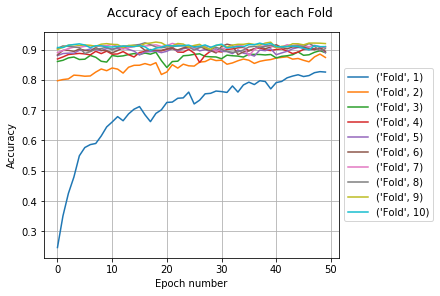

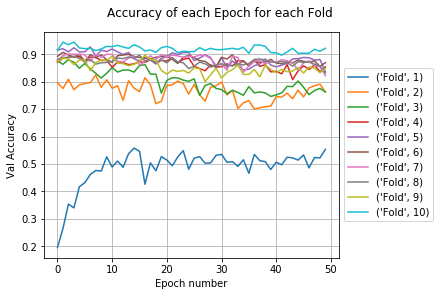

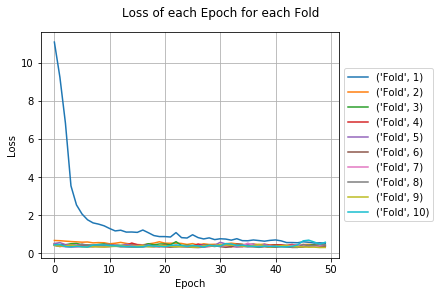

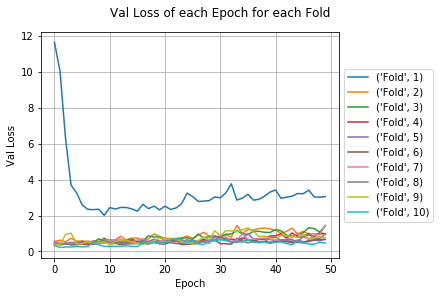

In [45]:
Graph_Epochs_model_1=Graph_func(Epoch_number,Epoch_array_accuracy,Val_accuracy_array,Loss_array,Val_Loss_array_1)

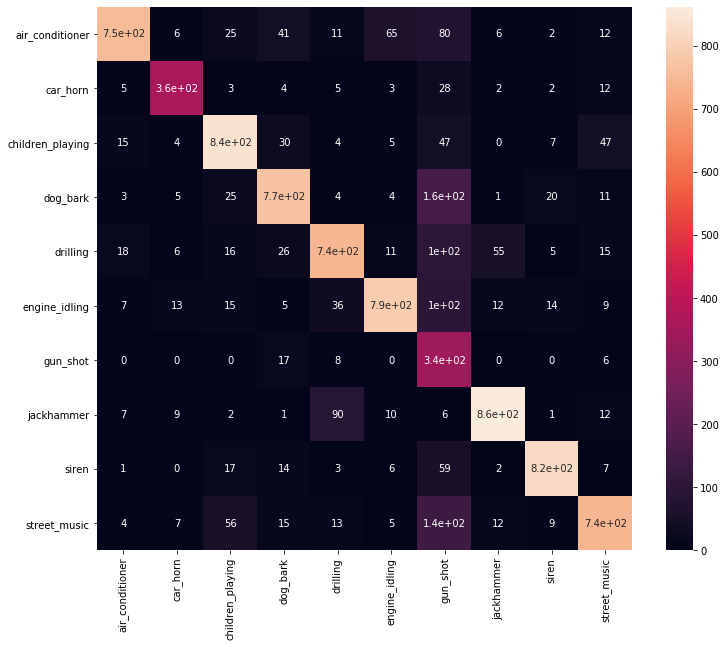

In [46]:
avg_cm = average_confusion_matrix(Confusion_Matrix_array)
plot_confusion_matrix(avg_cm)

In [47]:
Table_model_1=table_maker(Fold_accuracy,end_array,Avg_Accuracy,Time)

  Fold  Accuracy  Time Taken
0    1  0.704647    107.0957
1    2  0.848042    104.8047
2    3  0.877372    104.6145
3    4  0.892855     93.2907
4    5  0.895744     78.3482
5    6  0.901790     78.9358
6    7  0.908723     80.3517
7    8  0.906652     80.1965
8    9  0.914907     78.6552
9   10  0.910825     79.6025

    Average Accuracy  Total Time
0          0.876155    885.8955


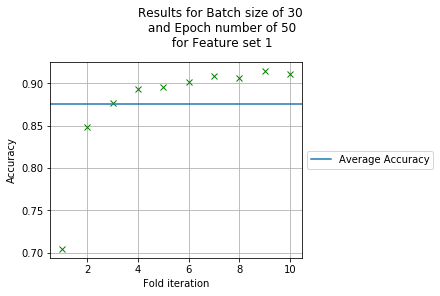

In [48]:
Graph_Avg_model_1=Graph_Avg_maker(Fold_accuracy,Avg_Accuracy)

#### Model 1 with no cross validation

In [49]:
for i in range(0, len(X_folds)):
    X_folds[i]=np.reshape(X_folds[i],(X_folds[i].shape[0], 40, 6))

X_train = np.vstack([X_folds[j] for j in range(0, len(Y_folds)-1)])
y_train = np.vstack([Y_folds_1[j] for j in range(0, len(Y_folds_1)-1)])
X_test = X_folds[9]
y_test = Y_folds[9]

Epoch_number=30

#compile model using accuracy to measure model performance
#model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
#train the model
cnn_model_history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=Epoch_number)
score_model_1_no_cross=model.evaluate(X_test, y_test)
accuracy_model_1_no_cross = score_model_1_no_cross[1]
print(f"\nAccuracy of model 1 with no cross validation: {round(accuracy_model_1_no_cross,3)}")

Train on 7895 samples, validate on 837 samples
Epoch 1/30
7895/7895 [==============================] - 1s 154us/step - loss: 0.5047 - acc: 0.9140 - val_loss: 0.4787 - val_acc: 0.9295
Epoch 2/30
7895/7895 [==============================] - 1s 155us/step - loss: 0.5035 - acc: 0.8960 - val_loss: 0.6010 - val_acc: 0.8769
Epoch 3/30
7895/7895 [==============================] - 1s 156us/step - loss: 0.4648 - acc: 0.9009 - val_loss: 0.6243 - val_acc: 0.8889
Epoch 4/30
7895/7895 [==============================] - 1s 156us/step - loss: 0.4447 - acc: 0.9064 - val_loss: 0.4683 - val_acc: 0.8937
Epoch 5/30
7895/7895 [==============================] - 1s 158us/step - loss: 0.3494 - acc: 0.9116 - val_loss: 0.4173 - val_acc: 0.9056
Epoch 6/30
7895/7895 [==============================] - 1s 154us/step - loss: 0.3639 - acc: 0.9079 - val_loss: 0.5975 - val_acc: 0.8769
Epoch 7/30
7895/7895 [==============================] - 1s 156us/step - loss: 0.3423 - acc: 0.9060 - val_loss: 0.4262 - val_acc: 0.9044
E

# Model 2

In [50]:
#adding layers and forming the model_1
#forming model_1
model_2=Sequential()
early_stopping_cb = EarlyStopping(patience=16, restore_best_weights=True)

    #add model layers
model_2.add(Conv2D(64, kernel_size=3, activation='relu', input_shape=(40,6,1)))
model_2.add(Conv2D(32, kernel_size=3, activation='relu'))
model_2.add(Flatten())
model_2.add(Dense(10, activation='softmax'))
    #compile model using accuracy to measure model performance
Model_2=model_2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [51]:
Accuracy_array_2=[]
accuracy_total_2=0
end_array_2=[]

Epoch_array_accuracy_2=[]
Loss_array_2=[]
Fold_accuracy_2=[]

Val_accuracy_array_2=[]
Val_Loss_array_2=[]

Avg_Accuracy_2=[]
Time_2=[]

accuracy_score=[]
Epoch_number=50
Batch_size=30

Confusion_Matrix_array = []
Metrics_f1 = []
Metrics_precision = []
Metrics_recall = []
Metrics_accuracy = []

Model_2=Model_run_nn_es(Model_2,model_2,X_folds_10,Y_folds_10,Accuracy_array_2,
                     accuracy_total_2,end_array_2,Epoch_array_accuracy_2,Loss_array_2,
                     Fold_accuracy_2,Val_accuracy_array_2,Val_Loss_array_2, Confusion_Matrix_array,
                     Metrics_f1, Metrics_precision, Metrics_recall, Metrics_accuracy)
Avg_Accuracy_2=Model_2[0]
Time_2=Model_2[1]


Fold #1
- - - - - - - - - - - - - - - - - - - -
(7859, 40, 6, 1) (7859, 10) (873, 40, 6, 1) (873, 10)
Accuracy of Fold 1 is 0.8401991347622927
Time to train Fold 1 : 78.8654 seconds.

Fold #2
- - - - - - - - - - - - - - - - - - - -
(7844, 40, 6, 1) (7844, 10) (888, 40, 6, 1) (888, 10)
Accuracy of Fold 2 is 0.9210315436730531
Time to train Fold 2 : 70.2984 seconds.

Fold #3
- - - - - - - - - - - - - - - - - - - -
(7807, 40, 6, 1) (7807, 10) (925, 40, 6, 1) (925, 10)
Accuracy of Fold 3 is 0.9414100467286112
Time to train Fold 3 : 58.2471 seconds.

Fold #4
- - - - - - - - - - - - - - - - - - - -
(7742, 40, 6, 1) (7742, 10) (990, 40, 6, 1) (990, 10)
Accuracy of Fold 4 is 0.9523378971258408
Time to train Fold 4 : 65.0028 seconds.

Fold #5
- - - - - - - - - - - - - - - - - - - -
(7796, 40, 6, 1) (7796, 10) (936, 40, 6, 1) (936, 10)
Accuracy of Fold 5 is 0.9564021435375055
Time to train Fold 5 : 62.3248 seconds.

Fold #6
- - - - - - - - - - - - - - - - - - - -
(7909, 40, 6, 1) (7909, 10) (82

In [52]:
print('Fold No, F-measure, Precision, Recall, Accuracy')
for i in range(10):
    print(f'{i}, {Metrics_f1[i]}, {Metrics_precision[i]}, {Metrics_recall[i]}, {Metrics_accuracy[i]}')
#     print(i + Metrics_f1 + ' , 'Metrics_precision + ' , 'Metrics_recall + ' , 'Metrics_accuracy)

Fold No, F-measure, Precision, Recall, Accuracy
0, 0.5205706773511031, 0.5194977154224217, 0.5509736540664376, 0.5509736540664376
1, 0.7992874281628544, 0.8092965238946221, 0.7995495495495496, 0.7995495495495496
2, 0.8087274617381471, 0.8321019820295357, 0.812972972972973, 0.812972972972973
3, 0.84284763491835, 0.8473581787433067, 0.8424242424242424, 0.8424242424242424
4, 0.89320437657065, 0.8995809897331324, 0.8931623931623932, 0.8931623931623932
5, 0.8967475814981795, 0.9034669283088266, 0.8955042527339003, 0.8955042527339003
6, 0.8982598149372443, 0.9083210982020994, 0.9009546539379475, 0.9009546539379475
7, 0.8968924735003235, 0.9003089174045797, 0.8957816377171216, 0.8957816377171216
8, 0.9091313615691309, 0.9120070697628222, 0.9093137254901961, 0.9093137254901961
9, 0.9677715463187637, 0.9684011401679355, 0.967741935483871, 0.967741935483871


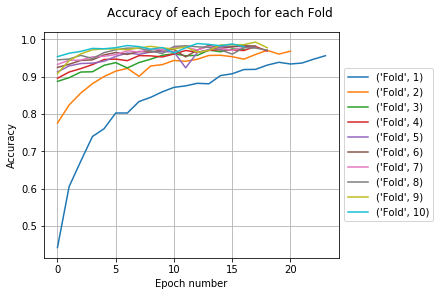

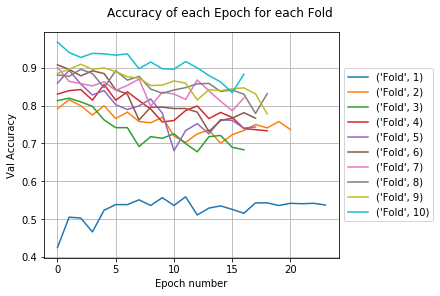

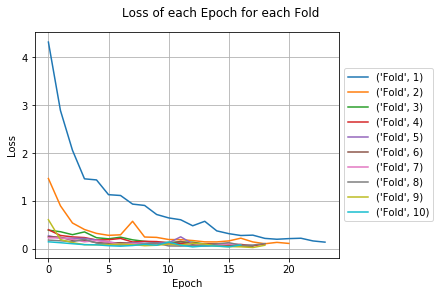

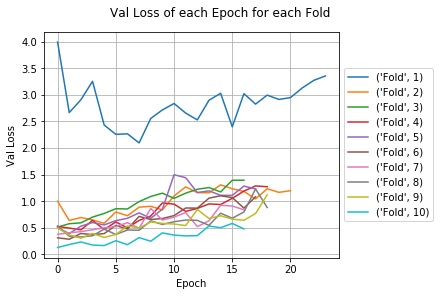

In [53]:
Graph_Epochs_model_2=Graph_func(Epoch_number,Epoch_array_accuracy_2,Val_accuracy_array_2,Loss_array_2,Val_Loss_array_2) 

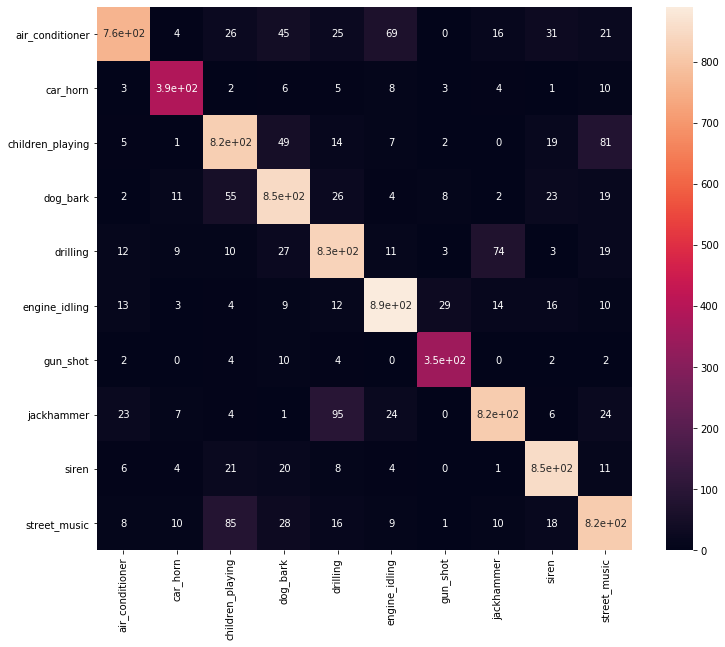

In [54]:
avg_cm = average_confusion_matrix(Confusion_Matrix_array)
plot_confusion_matrix(avg_cm)

In [55]:
Table_model_2=table_maker(Fold_accuracy_2,end_array_2,Avg_Accuracy_2,Time_2)

  Fold  Accuracy  Time Taken
0    1  0.840199     78.8654
1    2  0.921032     70.2984
2    3  0.941410     58.2471
3    4  0.952338     65.0028
4    5  0.956402     62.3248
5    6  0.963178     64.0333
6    7  0.964925     60.4681
7    8  0.968392     68.2521
8    9  0.971503     68.4447
9   10  0.976255     61.0877

    Average Accuracy  Total Time
0          0.945563    657.0244


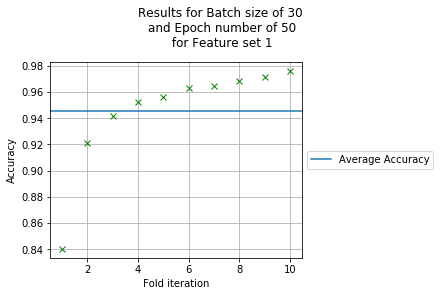

In [56]:
Graph_Avg_model_2=Graph_Avg_maker(Fold_accuracy_2,Avg_Accuracy_2)

### Model 2 with no cross validation

In [57]:
for i in range(0, len(X_folds)):
    X_folds[i]=np.reshape(X_folds[i],(X_folds[i].shape[0], 40, 6,1))

Epoch_number=30
X_train = np.vstack([X_folds_10[j] for j in range(0, len(Y_folds_10)-1)])
y_train = np.vstack([Y_folds_10[j] for j in range(0, len(Y_folds_10)-1)])
X_test = X_folds_10[9]
y_test = Y_folds_10[9]

cnn_model_2_history = model_2.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=Epoch_number)
score_model_2_no_cross=model_2.evaluate(X_test, y_test)
accuracy_model_2_no_cross = score_model_2_no_cross[1]
print(f"\nAccuracy of model 2 with no cross validation: {round(accuracy_model_2_no_cross,3)}")

Train on 7895 samples, validate on 837 samples
Epoch 1/30
7895/7895 [==============================] - 4s 453us/step - loss: 0.1325 - acc: 0.9635 - val_loss: 0.2659 - val_acc: 0.9355
Epoch 2/30
7895/7895 [==============================] - 4s 453us/step - loss: 0.1375 - acc: 0.9572 - val_loss: 0.2697 - val_acc: 0.9188
Epoch 3/30
7895/7895 [==============================] - 4s 457us/step - loss: 0.1061 - acc: 0.9728 - val_loss: 0.1686 - val_acc: 0.9415
Epoch 4/30
7895/7895 [==============================] - 4s 458us/step - loss: 0.0884 - acc: 0.9747 - val_loss: 0.3382 - val_acc: 0.8973
Epoch 5/30
7895/7895 [==============================] - 4s 458us/step - loss: 0.1323 - acc: 0.9624 - val_loss: 0.2956 - val_acc: 0.9008
Epoch 6/30
7895/7895 [==============================] - 4s 468us/step - loss: 0.1105 - acc: 0.9676 - val_loss: 0.2739 - val_acc: 0.9104
Epoch 7/30
7895/7895 [==============================] - 4s 464us/step - loss: 0.0861 - acc: 0.9753 - val_loss: 0.4182 - val_acc: 0.8614
E

## Model 3

In [58]:
model_3=Sequential()
early_stopping_cb = EarlyStopping(patience=17, restore_best_weights=True)

model_3.add(Conv2D(32,kernel_size=5,strides=1,padding="Same",activation="relu",input_shape=(40,6,1)))
model_3.add(MaxPooling2D(padding="same"))

model_3.add(Conv2D(64,kernel_size=5,strides=1,padding="same",activation="relu"))
model_3.add(MaxPooling2D(padding="same"))
model_3.add(Dropout(0.2))

model_3.add(Flatten())

model_3.add(Dense(128,activation="relu"))
model_3.add(Dropout(0.2))

model_3.add(Dense(10,activation="softmax"))

    #compiling
Model_3=model_3.compile(optimizer="adam",loss="categorical_crossentropy",metrics=["accuracy"])

In [59]:
Accuracy_array_3=[]
accuracy_total_3=0
end_array_3=[]

Epoch_array_accuracy_3=[]
Loss_array_3=[]
Fold_accuracy_3=[]

Val_accuracy_array_3=[]
Val_Loss_array_3=[]

Avg_Accuracy_3=[]
Time_3=[]

accuracy_score=[]
Epoch_number=50
Batch_size=30

Confusion_Matrix_array = []
Metrics_f1 = []
Metrics_precision = []
Metrics_recall = []
Metrics_accuracy = []

Model_3=Model_run_nn_es(Model_3,model_3,X_folds_10,Y_folds_10,Accuracy_array_3,
                     accuracy_total_3,end_array_3,Epoch_array_accuracy_3,Loss_array_3,
                     Fold_accuracy_3,Val_accuracy_array_3,Val_Loss_array_3, Confusion_Matrix_array,
                     Metrics_f1, Metrics_precision, Metrics_recall, Metrics_accuracy)
Avg_Accuracy_3=Model_3[0]
Time_3=Model_3[1]


Fold #1
- - - - - - - - - - - - - - - - - - - -
(7859, 40, 6, 1) (7859, 10) (873, 40, 6, 1) (873, 10)


/Users/sokratismourselas/opt/anaconda3/envs/r_env/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/sokratismourselas/opt/anaconda3/envs/r_env/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Accuracy of Fold 1 is 0.4827458964302835
Time to train Fold 1 : 267.0106 seconds.

Fold #2
- - - - - - - - - - - - - - - - - - - -
(7844, 40, 6, 1) (7844, 10) (888, 40, 6, 1) (888, 10)
Accuracy of Fold 2 is 0.6718916600992073
Time to train Fold 2 : 116.7421 seconds.

Fold #3
- - - - - - - - - - - - - - - - - - - -
(7807, 40, 6, 1) (7807, 10) (925, 40, 6, 1) (925, 10)
Accuracy of Fold 3 is 0.6857022899481817
Time to train Fold 3 : 96.2008 seconds.

Fold #4
- - - - - - - - - - - - - - - - - - - -
(7742, 40, 6, 1) (7742, 10) (990, 40, 6, 1) (990, 10)
Accuracy of Fold 4 is 0.7008388965260717
Time to train Fold 4 : 100.2056 seconds.

Fold #5
- - - - - - - - - - - - - - - - - - - -
(7796, 40, 6, 1) (7796, 10) (936, 40, 6, 1) (936, 10)
Accuracy of Fold 5 is 0.7175008162624651
Time to train Fold 5 : 118.3484 seconds.

Fold #6
- - - - - - - - - - - - - - - - - - - -
(7909, 40, 6, 1) (7909, 10) (823, 40, 6, 1) (823, 10)
Accuracy of Fold 6 is 0.7287966407446621
Time to train Fold 6 : 102.9631 sec

In [60]:
print('Fold No, F-measure, Precision, Recall, Accuracy')
for i in range(10):
    print(f'{i+1}, {Metrics_f1[i]}, {Metrics_precision[i]}, {Metrics_recall[i]}, {Metrics_accuracy[i]}')
#     print(i + Metrics_f1 + ' , 'Metrics_precision + ' , 'Metrics_recall + ' , 'Metrics_accuracy)

Fold No, F-measure, Precision, Recall, Accuracy
1, 0.4887751166894699, 0.5355091280025264, 0.4959908361970218, 0.4959908361970218
2, 0.7192476706551757, 0.7624693521599789, 0.7162162162162162, 0.7162162162162162
3, 0.708210053856749, 0.7574303959562053, 0.7016216216216217, 0.7016216216216217
4, 0.7397388469630808, 0.7761181431408921, 0.7414141414141414, 0.7414141414141414
5, 0.6911953753436814, 0.7383413218544478, 0.6826923076923077, 0.6826923076923077
6, 0.7358001539573877, 0.7947406197206598, 0.7132442284325637, 0.7132442284325637
7, 0.7987447889034992, 0.8314941690712978, 0.7911694510739857, 0.7911694510739857
8, 0.7511940309050379, 0.8137502246359049, 0.7245657568238213, 0.7245657568238213
9, 0.7375430623350889, 0.7912667413048752, 0.7169117647058824, 0.7169117647058824
10, 0.8379036170066957, 0.8619016619087334, 0.8303464755077659, 0.8303464755077659


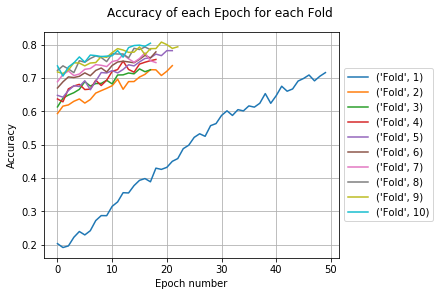

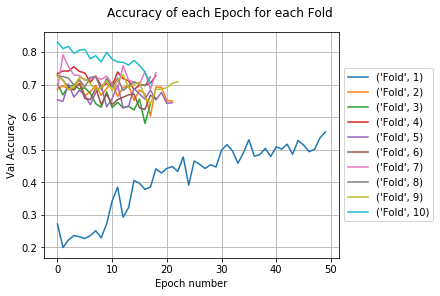

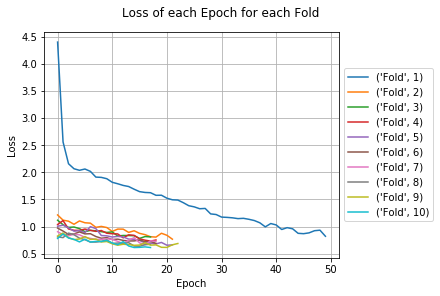

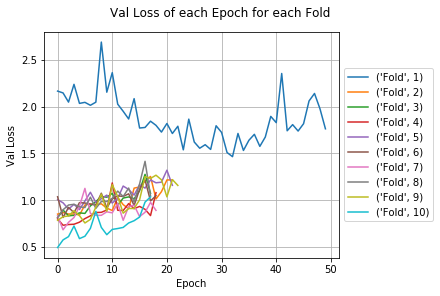

In [61]:
Graph_Epochs_model_3=Graph_func(Epoch_number,Epoch_array_accuracy_3,Val_accuracy_array_3,Loss_array_3,Val_Loss_array_3) 

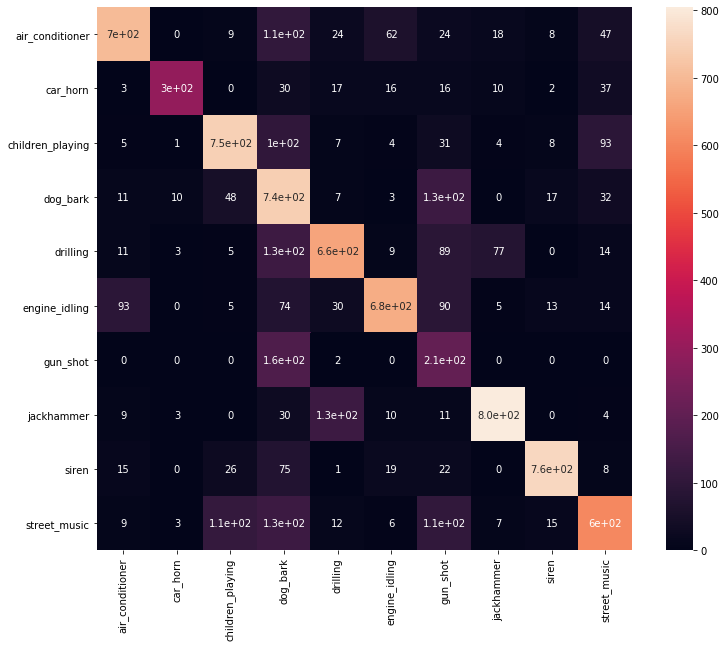

In [62]:
avg_cm = average_confusion_matrix(Confusion_Matrix_array)
plot_confusion_matrix(avg_cm)

In [63]:
Table_model_3=table_maker(Fold_accuracy_3,end_array_3,Avg_Accuracy_3,Time_3)

  Fold  Accuracy  Time Taken
0    1  0.482746    267.0106
1    2  0.671892    116.7421
2    3  0.685702     96.2008
3    4  0.700839    100.2056
4    5  0.717501    118.3484
5    6  0.728797    102.9631
6    7  0.737322    103.0098
7    8  0.758895     97.2867
8    9  0.766263    123.0964
9   10  0.766019     95.7665

    Average Accuracy  Total Time
0          0.701598     1220.63


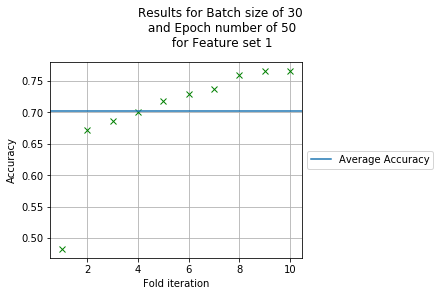

In [64]:
Graph_Avg_model_3=Graph_Avg_maker(Fold_accuracy_3,Avg_Accuracy_3)

In [67]:
X_train = np.vstack([X_folds_10[j] for j in range(0, len(Y_folds_10)-1)])
y_train = np.vstack([Y_folds_10[j] for j in range(0, len(Y_folds_10)-1)])
X_test = X_folds_10[9]
y_test = Y_folds_10[9]

Epoch_number=30
cnn_model_3_history = model_3.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=Epoch_number)
score_model_3_no_cross=model_3.evaluate(X_test, y_test)
accuracy_model_3_no_cross = score_model_3_no_cross[1]
print(f"\nAccuracy of model 3 with no cross validation: {round(accuracy_model_3_no_cross,3)}")

Train on 7895 samples, validate on 837 samples
Epoch 1/30
7895/7895 [==============================] - 4s 516us/step - loss: 0.7061 - acc: 0.7573 - val_loss: 0.6205 - val_acc: 0.7957
Epoch 2/30
7895/7895 [==============================] - 4s 511us/step - loss: 0.6950 - acc: 0.7719 - val_loss: 0.5892 - val_acc: 0.7945
Epoch 3/30
7895/7895 [==============================] - 4s 530us/step - loss: 0.6344 - acc: 0.7883 - val_loss: 0.6585 - val_acc: 0.7802
Epoch 4/30
7895/7895 [==============================] - 4s 560us/step - loss: 0.6627 - acc: 0.7834 - val_loss: 0.6541 - val_acc: 0.7802
Epoch 5/30
7895/7895 [==============================] - 4s 553us/step - loss: 0.6497 - acc: 0.7885 - val_loss: 0.7497 - val_acc: 0.7515
Epoch 6/30
7895/7895 [==============================] - 4s 543us/step - loss: 0.6758 - acc: 0.7752 - val_loss: 0.6390 - val_acc: 0.8005
Epoch 7/30
7895/7895 [==============================] - 4s 558us/step - loss: 0.6920 - acc: 0.7616 - val_loss: 0.6647 - val_acc: 0.7742
E

## Model 4

In [68]:
#adding layers and forming the model_1
#forming model_1
model_4=Sequential()

model_4.add(Conv2D(64,kernel_size=5,strides=1,padding="Same",activation="relu",input_shape=(40,6,1)))
model_4.add(MaxPooling2D(padding="same"))

model_4.add(Flatten())

model_4.add(Dense(10,activation="softmax"))
#compiling
Model_4=model_4.compile(optimizer="adam",loss="categorical_crossentropy",metrics=["accuracy"])

In [69]:
Accuracy_array_4=[]
accuracy_total_4=0
end_array_4=[]

Epoch_array_accuracy_4=[]
Loss_array_4=[]
Fold_accuracy_4=[]

Val_accuracy_array_4=[]
Val_Loss_array_4=[]

Avg_Accuracy_4=[]
Time_4=[]

accuracy_score=[]
Epoch_number=50
Batch_size=30

Confusion_Matrix_array = []
Metrics_f1 = []
Metrics_precision = []
Metrics_recall = []
Metrics_accuracy = []

Model_4=Model_run_nn_es_NO_EARLY_STOPPING(Model_4,model_4,X_folds_10,Y_folds_10,Accuracy_array_4,
                     accuracy_total_4,end_array_4,Epoch_array_accuracy_4,Loss_array_4,
                     Fold_accuracy_4,Val_accuracy_array_4,Val_Loss_array_4, Confusion_Matrix_array,
                     Metrics_f1, Metrics_precision, Metrics_recall, Metrics_accuracy)
Avg_Accuracy_4=Model_4[0]
Time_4=Model_4[1]


Fold #1
- - - - - - - - - - - - - - - - - - - -
(7859, 40, 6, 1) (7859, 10) (873, 40, 6, 1) (873, 10)


/Users/sokratismourselas/opt/anaconda3/envs/r_env/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/sokratismourselas/opt/anaconda3/envs/r_env/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Accuracy of Fold 1 is 0.5996742588251294
Time to train Fold 1 : 149.045 seconds.

Fold #2
- - - - - - - - - - - - - - - - - - - -
(7844, 40, 6, 1) (7844, 10) (888, 40, 6, 1) (888, 10)
Accuracy of Fold 2 is 0.6994110147883734
Time to train Fold 2 : 144.6261 seconds.

Fold #3
- - - - - - - - - - - - - - - - - - - -
(7807, 40, 6, 1) (7807, 10) (925, 40, 6, 1) (925, 10)
Accuracy of Fold 3 is 0.7168822851118578
Time to train Fold 3 : 144.6251 seconds.

Fold #4
- - - - - - - - - - - - - - - - - - - -
(7742, 40, 6, 1) (7742, 10) (990, 40, 6, 1) (990, 10)
Accuracy of Fold 4 is 0.7142262981186478
Time to train Fold 4 : 147.6006 seconds.

Fold #5
- - - - - - - - - - - - - - - - - - - -
(7796, 40, 6, 1) (7796, 10) (936, 40, 6, 1) (936, 10)
Accuracy of Fold 5 is 0.7246690610600105
Time to train Fold 5 : 143.529 seconds.

Fold #6
- - - - - - - - - - - - - - - - - - - -
(7909, 40, 6, 1) (7909, 10) (823, 40, 6, 1) (823, 10)
Accuracy of Fold 6 is 0.726015931224345
Time to train Fold 6 : 146.1844 secon

In [70]:
print('Fold No, F-measure, Precision, Recall, Accuracy')
for i in range(10):
    print(f'{i+1}, {Metrics_f1[i]}, {Metrics_precision[i]}, {Metrics_recall[i]}, {Metrics_accuracy[i]}')
#     print(i + Metrics_f1 + ' , 'Metrics_precision + ' , 'Metrics_recall + ' , 'Metrics_accuracy)

Fold No, F-measure, Precision, Recall, Accuracy
1, 0.42178833855467046, 0.4010733423396964, 0.4639175257731959, 0.4639175257731959
2, 0.5892843083965562, 0.5818726041273422, 0.6407657657657657, 0.6407657657657657
3, 0.5613983972501202, 0.5382194139582073, 0.6118918918918919, 0.6118918918918919
4, 0.6797719222152921, 0.6446200754826884, 0.7313131313131314, 0.7313131313131314
5, 0.618120420671806, 0.6023742513561517, 0.6698717948717948, 0.6698717948717948
6, 0.5960615152254601, 0.5478603795411918, 0.6634264884568651, 0.6634264884568651
7, 0.6125246507598879, 0.5905211562667678, 0.6754176610978521, 0.6754176610978521
8, 0.6392564496614693, 0.6019184617766997, 0.6960297766749379, 0.6960297766749379
9, 0.6320964838136727, 0.5950764472365507, 0.6936274509803921, 0.6936274509803921
10, 0.6502617444974346, 0.6180592916389148, 0.7084826762246117, 0.7084826762246117


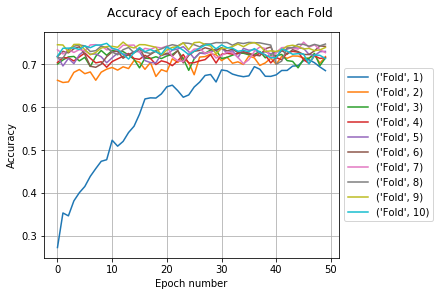

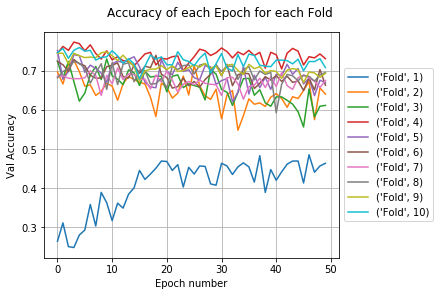

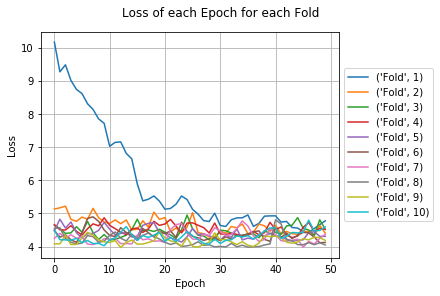

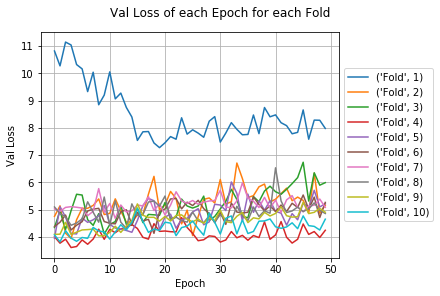

In [71]:
Graph_Epochs_model_4=Graph_func(Epoch_number,Epoch_array_accuracy_4,Val_accuracy_array_4,Loss_array_4,Val_Loss_array_4) 

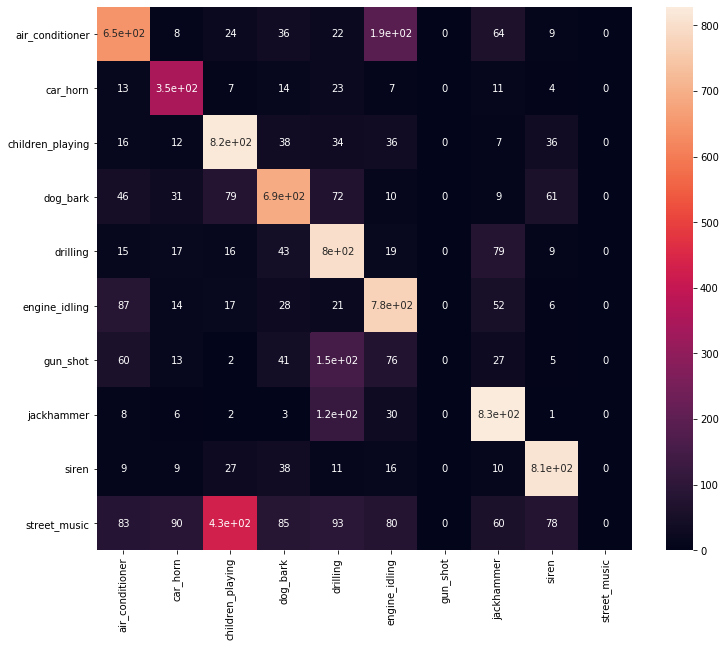

In [72]:
avg_cm = average_confusion_matrix(Confusion_Matrix_array)
plot_confusion_matrix(avg_cm)

In [73]:
Table_model_4=table_maker(Fold_accuracy_4,end_array_4,Avg_Accuracy_4,Time_4)

  Fold  Accuracy  Time Taken
0    1  0.599674    149.0450
1    2  0.699411    144.6261
2    3  0.716882    144.6251
3    4  0.714226    147.6006
4    5  0.724669    143.5290
5    6  0.726016    146.1844
6    7  0.731513    146.0830
7    8  0.738955    144.4478
8    9  0.739457    142.6347
9   10  0.731334    145.2217

    Average Accuracy  Total Time
0          0.712214   1453.9974


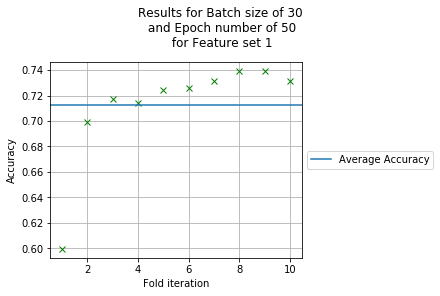

In [74]:
Graph_Avg_model_4=Graph_Avg_maker(Fold_accuracy_4,Avg_Accuracy_4)

In [75]:
X_train = np.vstack([X_folds_10[j] for j in range(0, len(Y_folds_10)-1)])
y_train = np.vstack([Y_folds_10[j] for j in range(0, len(Y_folds_10)-1)])
X_test = X_folds_10[9]
y_test = Y_folds_10[9]

Epoch_number=30
cnn_model_4_history = model_4.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=Epoch_number)
score_model_4_no_cross=model_4.evaluate(X_test, y_test)
accuracy_model_4_no_cross = score_model_4_no_cross[1]
print(f"\nAccuracy of model 4 with no cross validation: {round(accuracy_model_4_no_cross,4)}")

Train on 7895 samples, validate on 837 samples
Epoch 1/30
7895/7895 [==============================] - 3s 357us/step - loss: 4.6016 - acc: 0.7132 - val_loss: 4.5436 - val_acc: 0.7157
Epoch 2/30
7895/7895 [==============================] - 3s 355us/step - loss: 4.4509 - acc: 0.7226 - val_loss: 4.5133 - val_acc: 0.7157
Epoch 3/30
7895/7895 [==============================] - 3s 356us/step - loss: 4.4170 - acc: 0.7245 - val_loss: 4.5583 - val_acc: 0.7133
Epoch 4/30
7895/7895 [==============================] - 3s 367us/step - loss: 4.3282 - acc: 0.7301 - val_loss: 4.2365 - val_acc: 0.7348
Epoch 5/30
7895/7895 [==============================] - 3s 370us/step - loss: 4.2963 - acc: 0.7321 - val_loss: 4.3313 - val_acc: 0.7300
Epoch 6/30
7895/7895 [==============================] - 3s 377us/step - loss: 4.2338 - acc: 0.7364 - val_loss: 4.6666 - val_acc: 0.7085
Epoch 7/30
7895/7895 [==============================] - 3s 386us/step - loss: 4.3457 - acc: 0.7292 - val_loss: 4.3587 - val_acc: 0.7264
E

# Logistic regression results

In [77]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

X_folds, Y_folds = data_processor_log_reg(X_folds,Y_folds)

X_train = np.vstack([X_folds[j] for j in range(0, len(Y_folds)-1)])
y_train = np.vstack([Y_folds[j] for j in range(0, len(Y_folds)-1)])
X_test = X_folds[9]
y_test = Y_folds[9]

logreg = LogisticRegression()
logreg.fit(X_train, y_train)

y_pred = logreg.predict(X_test)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_test, y_test)))



/Users/sokratismourselas/opt/anaconda3/envs/r_env/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/sokratismourselas/opt/anaconda3/envs/r_env/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/sokratismourselas/opt/anaconda3/envs/r_env/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


Accuracy of logistic regression classifier on test set: 0.49


/Users/sokratismourselas/opt/anaconda3/envs/r_env/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


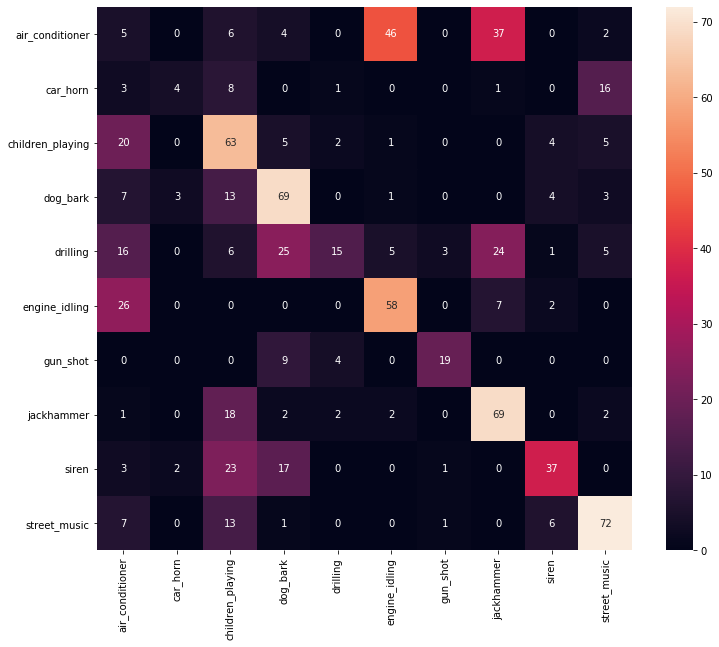

In [78]:
Confusion_matrix(X_test, y_test, model=logreg)

## Model from Github

In [79]:
# Model from GitHub

#adding layers and forming the model

#forming model
model_5=Sequential()

model_5.add(Conv2D(64,kernel_size=5,strides=1,padding="Same",activation="relu",input_shape=(40,6,1)))
model_5.add(MaxPooling2D(padding="same"))

model_5.add(Conv2D(128,kernel_size=5,strides=1,padding="same",activation="relu"))
model_5.add(MaxPooling2D(padding="same"))
model_5.add(Dropout(0.3))

model_5.add(Flatten())

model_5.add(Dense(256,activation="relu"))
model_5.add(Dropout(0.3))

model_5.add(Dense(512,activation="relu"))
model_5.add(Dropout(0.3))

model_5.add(Dense(10,activation="softmax"))

#compiling
Model_5=model_5.compile(optimizer="adam",loss="categorical_crossentropy",metrics=["accuracy"])

In [80]:
Accuracy_array_5=[]
accuracy_total_5=0
end_array_5=[]

Epoch_array_accuracy_5=[]
Loss_array_5=[]
Fold_accuracy_5=[]

Val_accuracy_array_5=[]
Val_Loss_array_5=[]

Avg_Accuracy_5=[]
Time_5=[]

accuracy_score=[]
Epoch_number=50
Batch_size=30

Confusion_Matrix_array = []
Metrics_f1 = []
Metrics_precision = []
Metrics_recall = []
Metrics_accuracy = []

Model_5=Model_run_nn_es_NO_EARLY_STOPPING(Model_5,model_5,X_folds_10,Y_folds_10,Accuracy_array_5,
                     accuracy_total_5,end_array_5,Epoch_array_accuracy_5,Loss_array_5,
                     Fold_accuracy_5,Val_accuracy_array_5,Val_Loss_array_5, Confusion_Matrix_array,
                     Metrics_f1, Metrics_precision, Metrics_recall, Metrics_accuracy)
Avg_Accuracy_5=Model_5[0]
Time_5=Model_5[1]


Fold #1
- - - - - - - - - - - - - - - - - - - -
(7859, 40, 6, 1) (7859, 10) (873, 40, 6, 1) (873, 10)


/Users/sokratismourselas/opt/anaconda3/envs/r_env/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/sokratismourselas/opt/anaconda3/envs/r_env/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Accuracy of Fold 1 is 0.11787504771419313
Time to train Fold 1 : 686.7546 seconds.

Fold #2
- - - - - - - - - - - - - - - - - - - -
(7844, 40, 6, 1) (7844, 10) (888, 40, 6, 1) (888, 10)
Accuracy of Fold 2 is 0.1111116777154513
Time to train Fold 2 : 703.4818 seconds.

Fold #3
- - - - - - - - - - - - - - - - - - - -
(7807, 40, 6, 1) (7807, 10) (925, 40, 6, 1) (925, 10)
Accuracy of Fold 3 is 0.11099269884717103
Time to train Fold 3 : 698.7148 seconds.

Fold #4
- - - - - - - - - - - - - - - - - - - -
(7742, 40, 6, 1) (7742, 10) (990, 40, 6, 1) (990, 10)
Accuracy of Fold 4 is 0.1110307414220558
Time to train Fold 4 : 690.2983 seconds.

Fold #5
- - - - - - - - - - - - - - - - - - - -
(7796, 40, 6, 1) (7796, 10) (936, 40, 6, 1) (936, 10)
Accuracy of Fold 5 is 0.11023858389444935
Time to train Fold 5 : 672.3727 seconds.

Fold #6
- - - - - - - - - - - - - - - - - - - -
(7909, 40, 6, 1) (7909, 10) (823, 40, 6, 1) (823, 10)
Accuracy of Fold 6 is 0.11748387912606482
Time to train Fold 6 : 674.925

In [81]:
print('Fold No, F-measure, Precision, Recall, Accuracy')
for i in range(10):
    print(f'{i+1}, {Metrics_f1[i]}, {Metrics_precision[i]}, {Metrics_recall[i]}, {Metrics_accuracy[i]}')
#     print(i + Metrics_f1 + ' , 'Metrics_precision + ' , 'Metrics_recall + ' , 'Metrics_accuracy)

Fold No, F-measure, Precision, Recall, Accuracy
1, 0.023666846534700327, 0.013196720878796036, 0.1145475372279496, 0.1145475372279496
2, 0.02279607542765438, 0.012681600519438356, 0.11261261261261261, 0.11261261261261261
3, 0.02109426499670402, 0.01168736303871439, 0.10810810810810811, 0.10810810810810811
4, 0.01853396348809193, 0.010203040506070809, 0.10101010101010101, 0.10101010101010101
5, 0.020625020625020623, 0.011414274234787055, 0.10683760683760683, 0.10683760683760683
6, 0.012611602729059193, 0.006826815329035078, 0.08262454434993925, 0.08262454434993925
7, 0.015082278844597171, 0.008225061374678887, 0.09069212410501193, 0.09069212410501193
8, 0.017077798861480076, 0.009365244536940686, 0.0967741935483871, 0.0967741935483871
9, 0.018352329796060964, 0.010098279507881584, 0.10049019607843138, 0.10049019607843138
10, 0.02222222222222222, 0.012345679012345678, 0.1111111111111111, 0.1111111111111111


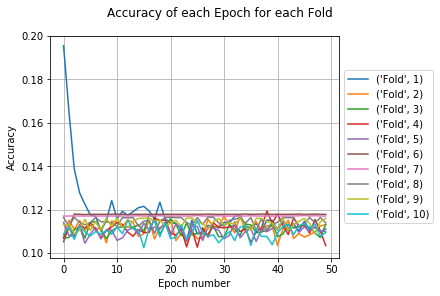

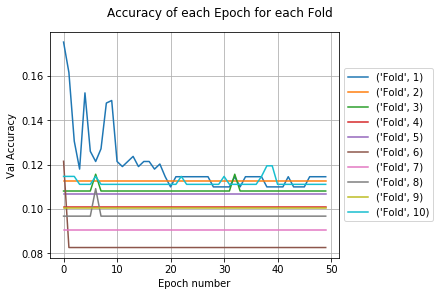

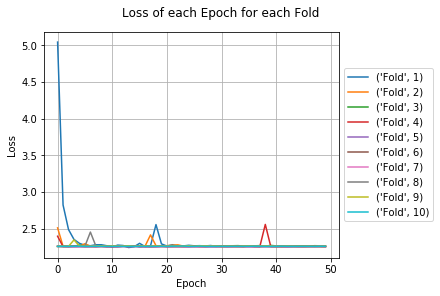

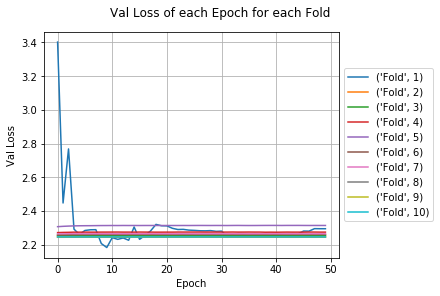

In [82]:
Graph_Epochs_model_5=Graph_func(Epoch_number,Epoch_array_accuracy_5,Val_accuracy_array_5,Loss_array_5,Val_Loss_array_5) 

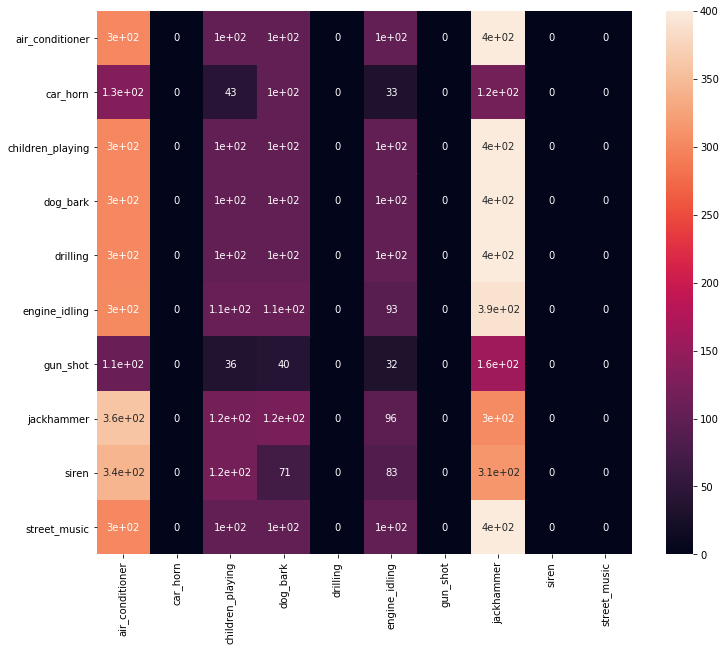

In [83]:
avg_cm = average_confusion_matrix(Confusion_Matrix_array)
plot_confusion_matrix(avg_cm)

In [84]:
Table_model_5=table_maker(Fold_accuracy_5,end_array_5,Avg_Accuracy_5,Time_5)

  Fold  Accuracy  Time Taken
0    1  0.117875    686.7546
1    2  0.111112    703.4818
2    3  0.110993    698.7148
3    4  0.111031    690.2983
4    5  0.110239    672.3727
5    6  0.117484    674.9254
6    7  0.117076    674.6542
7    8  0.114598    673.0907
8    9  0.113704    681.2707
9   10  0.109667    693.0029

    Average Accuracy  Total Time
0          0.113378   6848.5661


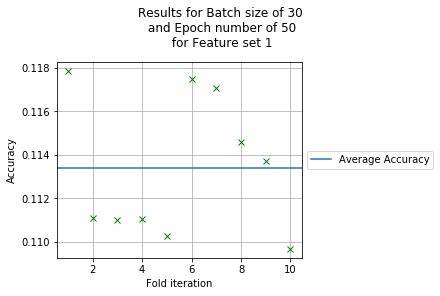

In [85]:
Graph_Avg_model_5=Graph_Avg_maker(Fold_accuracy_5,Avg_Accuracy_5)

### Github model with no cross validation

In [86]:
X_train = np.vstack([X_folds_10[j] for j in range(0, len(Y_folds_10)-1)])
y_train = np.vstack([Y_folds_10[j] for j in range(0, len(Y_folds_10)-1)])
X_test = X_folds_10[9]
y_test = Y_folds_10[9]

Epoch_number=30
cnn_model_5_history = model_5.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=Epoch_number)
score_model_5_no_cross=model_5.evaluate(X_test, y_test)
accuracy_model_5_no_cross = score_model_5_no_cross[1]
print(f"\nAccuracy of model 5 with no cross validation: {round(accuracy_model_5_no_cross,4)}")

Train on 7895 samples, validate on 837 samples
Epoch 1/30
7895/7895 [==============================] - 13s 2ms/step - loss: 2.2634 - acc: 0.1097 - val_loss: 2.2457 - val_acc: 0.1111
Epoch 2/30
7895/7895 [==============================] - 14s 2ms/step - loss: 2.2601 - acc: 0.1112 - val_loss: 2.2457 - val_acc: 0.1111
Epoch 3/30
7895/7895 [==============================] - 14s 2ms/step - loss: 2.2602 - acc: 0.1059 - val_loss: 2.2457 - val_acc: 0.1111
Epoch 4/30
7895/7895 [==============================] - 14s 2ms/step - loss: 2.2602 - acc: 0.1082 - val_loss: 2.2458 - val_acc: 0.1111
Epoch 5/30
7895/7895 [==============================] - 14s 2ms/step - loss: 2.2601 - acc: 0.1117 - val_loss: 2.2457 - val_acc: 0.1111
Epoch 6/30
7895/7895 [==============================] - 14s 2ms/step - loss: 2.2601 - acc: 0.1118 - val_loss: 2.2457 - val_acc: 0.1111
Epoch 7/30
7895/7895 [==============================] - 14s 2ms/step - loss: 2.2602 - acc: 0.1079 - val_loss: 2.2458 - val_acc: 0.1111
Epoch 8/

## Model Comparisson

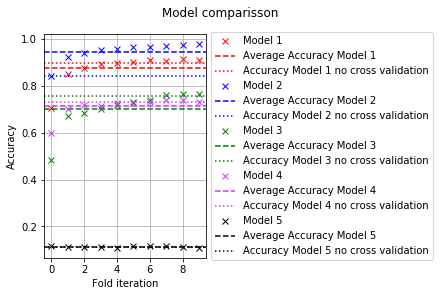

In [103]:
%matplotlib inline

fig, ax1 = plt.subplots(1, 1, constrained_layout=True, subplot_kw=dict())

ax1.plot(Fold_accuracy,"rx",label="Model 1")
ax1.axhline(y=Avg_Accuracy,label='Average Accuracy Model 1',color='r',ls="--")
ax1.axhline(y=accuracy_model_1_no_cross,label='Accuracy Model 1 no cross validation',color='r',ls=":")


ax1.plot(Fold_accuracy_2,"bx",label="Model 2")
ax1.axhline(y=Avg_Accuracy_2,label='Average Accuracy Model 2',color='b',ls="--")
ax1.axhline(y=accuracy_model_2_no_cross,label='Accuracy Model 2 no cross validation',color='b',ls=":")


ax1.plot(Fold_accuracy_3,"gx",label="Model 3")
ax1.axhline(y=Avg_Accuracy_3,label='Average Accuracy Model 3',color='g',ls="--")
ax1.axhline(y=accuracy_model_3_no_cross,label='Accuracy Model 3 no cross validation',color='g',ls=":")

ax1.plot(Fold_accuracy_4,"x", color="#cc33ff",label="Model 4")
ax1.axhline(y=Avg_Accuracy_4,label='Average Accuracy Model 4',color='#cc33ff',ls="--")
ax1.axhline(y=accuracy_model_4_no_cross,label='Accuracy Model 4 no cross validation',color='#cc33ff',ls=":")

ax1.plot(Fold_accuracy_5,"kx",label="Model 5")
ax1.axhline(y=Avg_Accuracy_5,label='Average Accuracy Model 5',color='k',ls="--")
ax1.axhline(y=accuracy_model_5_no_cross,label='Accuracy Model 5 no cross validation',color='k',ls=":")

#ax1.set_title('Results for a batch size of',Batch_size,'and',Epoch_number,'.')
fig.suptitle(f"Model comparisson")
ax1.set_xlabel("Fold iteration")
ax1.set_ylabel("Accuracy")
ax1.grid()
ax1.legend(loc='center left', bbox_to_anchor=(1, 0.5))